In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import pickle

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

import warnings
warnings.filterwarnings('ignore')

# EDA

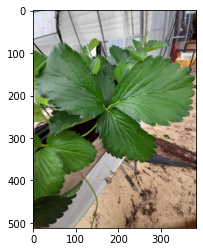

In [2]:
sample = glob('data/train/*')[np.random.randint(0, 1000)]

sample_csv = pd.read_csv(glob(sample+'/*.csv')[0])
sample_image = cv2.imread(glob(sample+'/*.jpg')[0])
sample_json = json.load(open(glob(sample+'/*.json')[0], 'r'))

plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
sample_csv = pd.read_csv(r'data/train/10045/10045.csv')
sample_csv

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,...,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-09-15 16:10:00,28.4,28.6,28.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,2021-09-15 16:00:00,29.2,29.5,28.8,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,2021-09-15 15:50:00,29.4,29.6,29.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,2021-09-15 15:40:00,29.1,29.2,28.9,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,2021-09-15 15:30:00,29.0,29.2,28.8,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2021-09-13 16:00:00,28.3,28.6,28.1,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
290,2021-09-13 15:50:00,28.6,28.6,28.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
291,2021-09-13 15:40:00,28.4,28.6,28.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
292,2021-09-13 15:30:00,28.9,29.1,28.7,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [4]:
# # image
# plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
# plt.show()

In [5]:
# json
sample_json

{'description': {'date': '20211015',
  'image': '19019.jpg',
  'task': 0,
  'width': 384,
  'time': '1009',
  'region': 0,
  'height': 512},
 'annotations': {'area': 3,
  'disease': '00',
  'grow': 12,
  'bbox': [{'x': 180.53561580882354,
    'h': 168.75147441789215,
    'y': 105.61699601715686,
    'w': 199.28745404411765}],
  'part': [],
  'risk': 0,
  'crop': 1}}

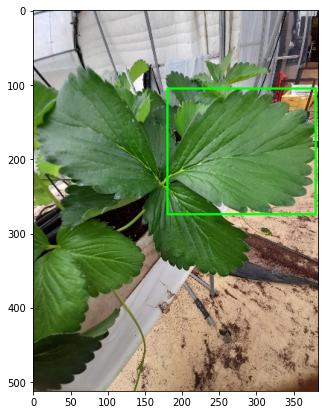

In [6]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0]
part_points = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

In [31]:
temp_max

array([18.6, 18.7, 18.4, 92.3, 92.4, 92.1, 11.0, 11.7, 10.2, '567.4',
       '570.0', '565.0'], dtype=object)

In [63]:
temp_csv_1 = pd.read_csv(csv_files[0])[csv_features[:-3]]
temp_csv_2 = pd.read_csv(csv_files[0])[csv_features[-3:]]
temp_csv_1 = temp_csv_1.replace('-', np.nan).dropna().reset_index(drop=True)
temp_csv_2 = temp_csv_2.replace('-', np.nan).dropna().reset_index(drop=True)
temp_csv = pd.concat([temp_csv_1, temp_csv_2], axis=1)
temp_csv = temp_csv.astype(float)

In [66]:
temp_csv_2

,내부 CO2 평균,내부 CO2 최고,내부 CO2 최저
0,492.2,499.0,486.0
1,507.2,512.0,502.0
2,515.1,519.0,512.0
3,515.9,520.0,511.0
4,516.5,519.0,512.0
...,...,...,...
289,476.3,479.0,471.0
290,479.7,483.0,475.0
291,483.8,489.0,481.0
292,490.5,493.0,485.0


In [64]:
temp_csv_1

,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 습도 1 평균,내부 습도 1 최고,내부 습도 1 최저,내부 이슬점 평균,내부 이슬점 최고,내부 이슬점 최저
0,9.0,9.6,8.5,81.5,82.0,80.8,6.1,6.9,5.9
1,8.7,9.3,8.1,85.4,85.7,84.9,6.3,6.8,5.7
2,7.9,8.4,7.4,81.9,82.7,81.6,5.0,5.1,4.3
3,7.4,7.9,6.9,86.9,87.4,85.9,5.4,6.0,5.0
4,6.9,7.2,6.6,83.3,84.0,82.7,4.4,4.5,4.3
...,...,...,...,...,...,...,...,...,...
583,8.7,8.9,8.4,89.7,90.1,89.2,7.3,7.5,6.5
584,8.8,9.0,8.7,85.3,85.5,85.0,6.6,6.8,6.6
585,8.2,8.4,8.0,89.9,90.1,89.6,6.5,6.5,6.5
586,8.5,8.6,8.4,85.5,85.8,85.3,6.4,6.8,5.8


In [65]:
temp_csv

,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 습도 1 평균,내부 습도 1 최고,내부 습도 1 최저,내부 이슬점 평균,내부 이슬점 최고,내부 이슬점 최저,내부 CO2 평균,내부 CO2 최고,내부 CO2 최저
0,9.0,9.6,8.5,81.5,82.0,80.8,6.1,6.9,5.9,492.2,499.0,486.0
1,8.7,9.3,8.1,85.4,85.7,84.9,6.3,6.8,5.7,507.2,512.0,502.0
2,7.9,8.4,7.4,81.9,82.7,81.6,5.0,5.1,4.3,515.1,519.0,512.0
3,7.4,7.9,6.9,86.9,87.4,85.9,5.4,6.0,5.0,515.9,520.0,511.0
4,6.9,7.2,6.6,83.3,84.0,82.7,4.4,4.5,4.3,516.5,519.0,512.0
...,...,...,...,...,...,...,...,...,...,...,...,...
583,8.7,8.9,8.4,89.7,90.1,89.2,7.3,7.5,6.5,NaN,NaN,NaN
584,8.8,9.0,8.7,85.3,85.5,85.0,6.6,6.8,6.6,NaN,NaN,NaN
585,8.2,8.4,8.0,89.9,90.1,89.6,6.5,6.5,6.5,NaN,NaN,NaN
586,8.5,8.6,8.4,85.5,85.8,85.3,6.4,6.8,5.8,NaN,NaN,NaN


In [62]:
temp_min

array([4.9, 5.0, 4.9, 41.3, 42.4, 39.6, 2.4, 2.6, 1.7, '-', '-', '-'],
      dtype=object)

# 환경 데이터 통계량 계산 for MinMax Scaling

In [19]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
'내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저', '내부 CO2 평균', '내부 CO2 최고', '내부 CO2 최저']

csv_files = sorted(glob('data/train/*/*.csv'))

## ADDED
lens = []
lens_1 = []
lens_2 = []

total_sum = 0
total_cnt = 0

temp_csv_1 = pd.read_csv(csv_files[0])[csv_features[:-3]]
temp_csv_2 = pd.read_csv(csv_files[0])[csv_features[-3:]]
temp_csv_1 = temp_csv_1.replace('-', np.nan).dropna()
temp_csv_2 = temp_csv_2.replace('-', np.nan).dropna()
temp_csv = pd.concat([temp_csv_1, temp_csv_2], axis=1)
temp_csv = temp_csv.astype(float)
total_cnt+=len(temp_csv)
# temp_csv = temp_csv.replace('-', np.nan).dropna()
#   
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
total_sum += temp_csv.sum().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv_1 = pd.read_csv(csv)[csv_features[:-3]]
    temp_csv_2 = pd.read_csv(csv)[csv_features[-3:]]
    
    temp_csv_1 = temp_csv_1.replace('-', np.nan).dropna().astype(float)
    temp_csv_2 = temp_csv_2.replace('-', np.nan).dropna().astype(float)

    
    # temp_csv = pd.concat([temp_csv_1, temp_csv_2], axis=1)
    
    # lens_1.append(len(temp_csv_1))
    # lens_2.append(len(temp_csv_2))
    # lens.append(len(temp_csv))
    
    if len(temp_csv_1) == 0 and len(temp_csv_2) == 0:
        continue    # nan값이면 최대, 최솟값 계산하지 않음
    
    temp_max_1, temp_min_1 = temp_csv_1.max().to_numpy(), temp_csv_1.min().to_numpy()
    temp_max_2, temp_min_2 = temp_csv_2.max().to_numpy(), temp_csv_2.min().to_numpy()

    temp_sum_1 = temp_csv.sum().to_numpy()

    total_sum += temp_sum
    total_cnt += len(temp_csv)

    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}

# ADDED # feature 별 평균의 dict 생성 
csv_means = total_sum/total_cnt
csv_feature_mean_dict = {csv_features[i]:csv_means[i] for i in range(len(csv_features))}

# save data
with open('csv_feature_dict_co2.pkl','wb') as fw:
    pickle.dump(csv_feature_dict, fw)

with open('csv_feature_mean_dict_co2.pkl','wb') as fw:
    pickle.dump(csv_feature_mean_dict, fw)

100%|██████████| 5766/5766 [01:18<00:00, 73.15it/s]


In [23]:
pd.DataFrame(lens_1).value_counts()

294    3562
588     579
291     404
77      156
574     156
       ... 
186       1
46        1
45        1
43        1
590       1
Length: 82, dtype: int64

In [24]:
pd.DataFrame(lens_2).value_counts()

294    3080
0      2104
291     160
280     156
233      83
245      47
240      41
262      27
152      24
241      11
154       9
263       5
286       5
295       5
283       3
285       3
264       2
156       1
dtype: int64

In [25]:
pd.DataFrame(lens).value_counts()

294    3562
588     579
291     404
77      156
574     156
       ... 
186       1
46        1
45        1
43        1
590       1
Length: 82, dtype: int64

In [27]:
# load data

with open('csv_feature_dict_co2.pkl', 'rb') as fr:
    csv_feature_dict = pickle.load(fr)

with open('csv_feature_mean_dict_co2.pkl', 'rb') as fr:
    csv_feature_mean_dict = pickle.load(fr)

print(csv_feature_dict)
print(csv_feature_mean_dict)

{'내부 온도 1 평균': [3.4, 47.3], '내부 온도 1 최고': [3.4, 47.6], '내부 온도 1 최저': [3.3, 47.0], '내부 습도 1 평균': [23.7, 100.0], '내부 습도 1 최고': [25.9, 100.0], '내부 습도 1 최저': [0.0, 100.0], '내부 이슬점 평균': [0.1, 34.5], '내부 이슬점 최고': [0.2, 34.7], '내부 이슬점 최저': [0.0, 34.4], '내부 CO2 평균': [nan, nan], '내부 CO2 최고': [nan, nan], '내부 CO2 최저': [nan, nan]}
{'내부 온도 1 평균': 20.675539141883576, '내부 온도 1 최고': 20.819257762827633, '내부 온도 1 최저': 20.52547190556876, '내부 습도 1 평균': 79.2767723981847, '내부 습도 1 최고': 80.15257756078621, '내부 습도 1 최저': 78.40344628996725, '내부 이슬점 평균': 16.658427260768335, '내부 이슬점 최고': 16.95047020427353, '내부 이슬점 최저': 16.368507140097364, '내부 CO2 평균': 273.5881053869484, '내부 CO2 최고': 276.1094730371405, '내부 CO2 최저': 271.09402803171935}


# CustomDataset 제작

In [ ]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'} 

In [ ]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'

In [ ]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = max_len
        self.label_encoder = label_encoder
        # self.img_transform = transform # ADDED

    def __len__(self):
        return len(self.files)

    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('\\')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]

            # ADDED 
            # 쓸 feature에 대해서만 평균값으로 imputation 진행 
            for key in self.csv_feature_dict.keys():
                df[key] = df[key].replace('-', csv_feature_mean_dict[key])
            # df = df.replace('-', 0) ###Original###

            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:] # max_len 까지만 df 사용, 그 이전은 0  
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        # print(len(csv_feature))

        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(380, 380), interpolation=cv2.INTER_CUBIC) # ADDED 
        img = img.astype(np.float32)/255   # MINMAX SCALING
        img = np.transpose(img, (2,0,1))
        
        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                # 'df' : df,
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                # 'df' : df,
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

# Hyperparameter

In [ ]:
device = torch.device("cuda:0")
batch_size = 24
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 512     # RNN hidden
num_features = len(csv_feature_dict)
max_len = 144

# CNN

# RNN
rnn_fc_dim = 1000
fc_dropout_rate = 0.2
epochs = 20

# Save 설정
save_name = 'JS_effb4+LSTM_co2_v1'
save_path = f'models/{name}.pt'
print(f'class수 : {class_n}')
print(f'feature 수: {num_features}')

# 데이터셋 구성

In [ ]:
train = sorted(glob('data/train/*'))
test = sorted(glob('data/test/*'))

labelsss = pd.read_csv('data/train_gt.csv')['label']
train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [ ]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)
test_dataset = CustomDataset(test, mode = 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 모델

## 이미지 분류 모델 : EfficientNetb4

In [ ]:
from efficientnet_pytorch import EfficientNet
from torchinfo import summary

class CNN_Encoder(nn.Module):
    def __init__(self, embedding_dim, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b4')    # (input, output) = (380, 1792)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

## 시계열 모델 : LSTM

In [ ]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, rnn_fc_dim)
        self.final_layer = nn.Linear(1000+rnn_fc_dim, class_n) # cnn out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp) # hidden dim : (Batch, csv_feature, embedding_dim)
        hidden = hidden.view(hidden.size(0), -1)    # (Batch, num_features*embedding_dim)
        hidden = self.rnn_fc(hidden)    # (, 1000)

        fc_input = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        output = self.final_layer(fc_input)
        output = self.dropout(output)
        return output

## 앙상블

In [ ]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)  # concat - 1000+1000
        
        return output

In [ ]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=fc_dropout_rate)
model = model.to(device)

In [ ]:
# hidden dim : (Batch, csv_feature, embedding_dim)
# final output : (Batch, n_class)
# model = model.cpu()
# sample_batch = next(iter(train_dataloader))
# sample_img = sample_batch['img']
# sample_csv = sample_batch['csv_feature']
# sample_out = model(sample_img, sample_csv)
# sample_out
# OUT SHAPE : (16, 111)
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x2000 and 2792x111)

In [ ]:
import gc
gc.collect()

# 학습

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [ ]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    # Training
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))
    
    # Validation
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1]:  # 현재 모델이 성능 최댓값이면 저장 
        torch.save(model.state_dict(), save_path)
        
# 10e - 17min

# 학습 결과

In [ ]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(metric_plot, label='train_metric')
plt.plot(val_metric_plot, label='val_metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.title("F-1", fontsize=25)
plt.legend()
plt.show()

In [ ]:
max_val = np.max(val_metric_plot)
print(max_val)

# 추론

In [ ]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['csv_feature'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=fc_dropout_rate)

model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

preds = predict(test_dataloader)
# 25min

In [ ]:
preds = np.array([label_decoder[int(val)] for val in preds])

# 제출 파일 생성

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission['label'] = preds
submission

In [ ]:
submission.to_csv(f'{save_name}_{max_val:6f}.csv', index=False)